In [39]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

from collections import Counter
from functools import reduce
import random
import re
import gc
from tqdm.auto import tqdm
import time
import random

import torch
import torch.utils.data
import torch.nn as nn
import torch.tensor as tensor
import torch.autograd as autograd
from torch.autograd import Variable

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

tqdm.pandas()

## Load dataset

In [2]:
DATA_DIR = "../input"
TRAIN_CSV = f"{DATA_DIR}/train.csv"
TEST_CSV = f"{DATA_DIR}/test.csv"

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Train shape: {train_df.shape}; cols: {list(train_df.columns)}")
print(f"Test shape: {test_df.shape}; cols: {list(test_df.columns)}")

Train shape: (1306122, 3); cols: ['qid', 'question_text', 'target']
Test shape: (375806, 2); cols: ['qid', 'question_text']


In [8]:
sincere = train_df.loc[train_df['target'] == 0]
insincere = train_df.loc[train_df['target'] == 1]

print(
    f"sincere: {len(sincere)} ({round(100.0 * len(sincere)/len(train_df), 3)}%); "
    f"insincere: {len(insincere)} ({round(100.0 * len(insincere)/len(train_df), 3)}%); "
    f"ratio (-/+): {round(len(sincere)/len(insincere), 3)}; "
    f"ratio (+/-): {round(len(insincere)/len(sincere), 3)}\n"
)

print(
    f"sincere: {sincere.iloc[random.randint(0, len(sincere))]['question_text']}\n\n"
    f"insincere: {insincere.iloc[random.randint(0, len(insincere))]['question_text']}"
)
print()

sincere: 1225312 (93.813%); insincere: 80810 (6.187%); ratio (-/+): 15.163; ratio (+/-): 0.066

sincere: Is Santa a time traveler?

insincere: Why do Americans marry more than one person when it is considered adultery as per the Bible?



## Load embeddings

In [7]:
EMB_GLOVE = f"{DATA_DIR}/embeddings/glove.840B.300d/glove.840B.300d.txt"
EMB_WORD2VEC = f"{DATA_DIR}/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
EMB_PARAGRAM = f"{DATA_DIR}/embeddings/paragram_300_sl999/paragram_300_sl999.txt"
EMB_WIKI = f"{DATA_DIR}/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"

### word2vec

In [9]:
emb_word2vec = KeyedVectors.load_word2vec_format(EMB_WORD2VEC, binary=True)

In [31]:
print(f"{len(emb_word2vec.vocab)} x {emb_word2vec['the'].size}")
print("xiaomi" in emb_word2vec)

3000000 x 300
False


### GloVe

In [13]:
def load_glove():
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMB_GLOVE, encoding='latin'))
        
    return embeddings_index

emb_glove = load_glove()

In [32]:
print(f"{len(emb_glove)} x {emb_glove['a'].size}")
print("xiaomi" in emb_glove)

2196016 x 300
True


In [37]:
_glove_not_w2v = Counter()
_w2v_not_glove = Counter()

for w in tqdm(emb_word2vec.vocab):
    if w not in emb_glove:
        _w2v_not_glove[w] += 1

for w in tqdm(emb_glove):
    if w not in emb_word2vec:
        _glove_not_w2v[w] += 1

In [49]:
print(f"glove not w2v: {len(_glove_not_w2v)}; w2v not glove: {len(_w2v_not_glove)}")
print("-" * 64)
print(random.sample(set(_w2v_not_glove), 20))
print("-" * 64)
print(random.sample(set(_glove_not_w2v), 20))

glove not w2v: 1546688; w2v not glove: 2350672
----------------------------------------------------------------
['mitotic_spindles', 'Boeckenstedt', 'starter_Casey_Fossum', 'VXL_Instruments', 'Socio_Economic_Assessment', 'M._Scaparrotti', 'Pharmion_Vidaza', 'scarlet_tunics', 'ANNA_SAUNDERS', 'Stateline_Speedway', 'Plastipak_Packaging_Inc.', 'submarine_chasers', 'St._Joesph', 'sectorals', 'Chris_Heighington', 'nonferrous_materials', 'Zarfati', 'Dominus_Iesus', 'Raúl_Martínez', 'glutes_quads']
----------------------------------------------------------------
['@number', 'Multiphoton', 'over-exploitation', 'pferd', 'calaca', 'variegatum', '2014Wed', 'Map/Parcel', '2003-10-13', 'propertyApproximate', "d'exposition", 'THEM.I', 'REPLENISHMENT', '2010-July', '27352', 'SAi', 'ROSEWATER', 'desander', '25,319', '910c']


## Clean dataset

In [50]:
PUNCTUATION = {
    'sep'   : u'\u200b' + "/-'´‘…—−–",
    'keep'  : "&",
    'remove': '?!.,，"#$%\'()*+-/:;<=>@[\\]^_`{|}~“”’™•°'
}

GLOVE_SYN_DICT = {
    'cryptocurrencies': 'crypto currencies',
    'ethereum'        : 'crypto currency',
    'fortnite'        : 'video game',
    'quorans'         : 'quora members',
    'brexit'          : 'britain exit',
    'redmi'           : 'xiaomi',
    '√'               : 'square root',
    '÷'               : 'division',
    '∞'               : 'infinity',
    '€'               : 'euro',
    '£'               : 'pound sterling',
    '$'               : 'dollar',
    '₹'               : 'rupee',
    '×'               : 'product',
    'ã'               : 'a',
    'è'               : 'e',
    'é'               : 'e',
    'ö'               : 'o',
    '²'               : 'squared',
    '∈'               : 'in',
    '∩'               : 'intersection',
    u'\u0398'         : 'Theta',
    u'\u03A0'         : 'Pi',
    u'\u03A9'         : 'Omega',
    u'\u0392'         : 'Beta',
    u'\u03B8'         : 'theta',
    u'\u03C0'         : 'pi',
    u'\u03C9'         : 'omega',
    u'\u03B2'         : 'beta',
}


def tokenize(s: str):
    return list(map(lambda w: w.strip(), s.split()))


def clean_text(x):
    x = x.lower()

    for p in PUNCTUATION['sep']:
        x = x.replace(p, " ")
    for p in PUNCTUATION['keep']:
        x = x.replace(p, f" {p} ")
    for p in PUNCTUATION['remove']:
        x = x.replace(p, "")

    return x


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)

    return x


def clean_syn(x):
    regex = re.compile('(%s)' % '|'.join(GLOVE_SYN_DICT.keys()))
    return regex.sub(lambda m: GLOVE_SYN_DICT.get(m.group(0), ''), x)


def clean_all(x):
    x = clean_text(x)
    x = clean_syn(x)
    return x
    


def build_vocabulary(df: pd.DataFrame) -> Counter:
    sentences = df.progress_apply(tokenize).values
    vocab = Counter()
    s_len = []
    
    for sentence in tqdm(sentences):  
        s_len.append(len(sentence))
        for word in sentence:
            vocab[word] += 1
    return vocab, np.array(s_len)

In [51]:
# clean
train_df["clean_question_text"] = train_df["question_text"].progress_apply(clean_all)
test_df["clean_question_text"] = test_df["question_text"].progress_apply(clean_all)

# vocab
train_vocab, train_s_len = build_vocabulary(train_df["clean_question_text"])
test_vocab, test_s_len = build_vocabulary(test_df["clean_question_text"])

train: DescribeResult(nobs=1306122, minmax=(0, 135), mean=12.984829135410015, variance=51.69376833334594, skewness=1.7884541192177796, kurtosis=4.158534049201138), median: 11.0
test: DescribeResult(nobs=375806, minmax=(1, 87), mean=12.991950634103766, variance=51.59271071611117, skewness=1.7865802630622394, kurtosis=4.114101024621738), median: 11.0


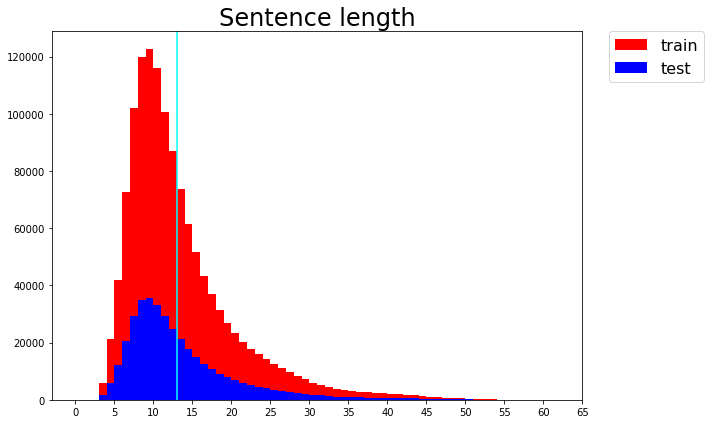

In [52]:
d_train = scipy.stats.describe(train_s_len)
d_test = scipy.stats.describe(test_s_len)
print(f"train: {d_train}, median: {np.median(train_s_len)}")
print(f"test: {d_test}, median: {np.median(test_s_len)}")

nb = 60

plt.figure(figsize=(10, 6))

plt.hist(train_s_len, bins=nb, range=[0, 60], facecolor='red', label='train')

plt.hist(test_s_len, bins=nb, range=[0, 60], facecolor='blue', label='test')
plt.axvline(x=d_test.mean, color='cyan')

plt.title("Sentence length", size=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 16})
plt.xticks([5*i for i in range(14)])
plt.tight_layout()
plt.show()

# Most common words

In [56]:
_n = 20
exclude = [
    "the", "of", "and", "to", "a", "in", "is", "i",
    "that", "it", "for", "you", "was", "with", "on",
    "as", "have", "but", "be", "they"
]

for w in exclude:
    del train_vocab[w]
    del test_vocab[w]
    
Tmc = train_vocab.most_common()
tmc = test_vocab.most_common()

for i in range(_n):
    print(f"{Tmc[i]} -- {tmc[i]}")

('what', 469057) -- ('what', 135120)
('how', 290151) -- ('how', 82786)
('do', 253179) -- ('do', 71990)
('are', 243018) -- ('are', 70096)
('can', 184467) -- ('can', 53100)
('why', 163836) -- ('why', 46953)
('my', 112622) -- ('my', 32692)
('if', 98905) -- ('if', 28318)
('or', 94575) -- ('or', 27120)
('does', 86436) -- ('does', 24797)
('s', 71998) -- ('s', 20899)
('from', 69837) -- ('from', 19894)
('your', 67700) -- ('your', 19429)
('an', 67463) -- ('an', 19122)
('which', 65832) -- ('which', 18771)
('should', 64559) -- ('should', 18607)
('when', 62881) -- ('when', 18246)
('get', 62758) -- ('get', 18193)
('best', 62478) -- ('best', 17969)
('would', 61496) -- ('would', 17594)


In [57]:
test_not_in_train = Counter()
train_not_in_test = Counter()

for w in test_vocab:
    if w not in train_vocab:
        test_not_in_train[w] += 1

for w in train_vocab:
    if w not in test_vocab:
        train_not_in_test[w] += 1
        
train_uniq_words = set(train_vocab.keys())
test_uniq_words = set(test_vocab.keys())
uniq_words = set(train_uniq_words.union(test_uniq_words))
all_oov = Counter()

for w in uniq_words:
    if w not in emb_glove:
        all_oov[w] += 1
        
print(f"train not in test: {len(train_not_in_test)}")
print(f"test not in train: {len(test_not_in_train)}")
print(f"train uniq: {len(train_uniq_words)}")
print(f"test uniq: {len(test_uniq_words)}")
print(f"total uniq words: {len(uniq_words)}")

# all_oov.most_common(10)
test_not_in_train.most_common(10)

train not in test: 132537
test not in train: 31251
train uniq: 207081
test uniq: 105795
total uniq words: 238332


[('thauncyent', 1),
 ('5mn', 1),
 ('babysitted', 1),
 ('sunar', 1),
 ('appareils', 1),
 ('grenadier', 1),
 ('flatshare', 1),
 ('penibsula', 1),
 ('communtities', 1),
 ('monterjobcom', 1)]

In [58]:
def get_emb_vocab_coverage(vocab, emb) -> (Counter, Counter):
    oov = Counter() # out-of-vocab
    inv = Counter() # in-vocab
    oov_uniq_num = inv_uniq_num = 0.0
    oov_all_num = inv_all_num = 0.0
    
    for w in tqdm(vocab):
        if w in emb:
            inv[w] = vocab[w]
            inv_uniq_num += 1
            inv_all_num += vocab[w]
        else:
            oov[w] = vocab[w]
            oov_uniq_num += 1
            oov_all_num += vocab[w]
    
    cov_uniq = 100.0 * round(inv_uniq_num / len(vocab), 5)
    cov_all = 100.0 * round(inv_all_num / (inv_all_num + oov_all_num), 5)
    
    print(f"oov_uniq: {oov_uniq_num}; inv_uniq: {inv_uniq_num}; all_uniq: {len(vocab)}")
    print("embeddings-vocabulary coverage (unique): %.3f%%" % cov_uniq)
    print("embeddings-vocabulary coverage (all text): %.3f%%" % cov_all)
    
    return oov, inv

In [65]:
oov, inv = get_emb_vocab_coverage(train_vocab, emb_glove)
oov.most_common(1000)


oov_uniq: 81578.0; inv_uniq: 125503.0; all_uniq: 207081
embeddings-vocabulary coverage (unique): 60.606%
embeddings-vocabulary coverage (all text): 98.980%


[('paytm', 356),
 ('kvpy', 356),
 ('iiser', 346),
 ('iisc', 278),
 ('jinping', 211),
 ('viteee', 185),
 ('iocl', 177),
 ('nmims', 163),
 ('rohingya', 157),
 ('upes', 157),
 ('iitians', 147),
 ('cpec', 146),
 ('nsit', 145),
 ('coinbase', 145),
 ('jadavpur', 138),
 ('oneplus', 138),
 ('udemy', 126),
 ('lyft', 125),
 ('bahubali', 123),
 ('uceed', 123),
 ('afcat', 123),
 ('coep', 118),
 ('bhakts', 115),
 ('demonetisation', 115),
 ('machedo', 108),
 ('gdpr', 107),
 ('adityanath', 106),
 ('upsee', 105),
 ('nlu', 105),
 ('boruto', 102),
 ('upwork', 101),
 ('bnbr', 100),
 ('chsl', 99),
 ('kernan', 96),
 ('amcat', 94),
 ('josaa', 93),
 ('vishwanathan', 93),
 ('alshamsi', 92),
 ('kylo', 92),
 ('udacity', 91),
 ('dceu', 90),
 ('iitian', 87),
 ('litecoin', 87),
 ('sjws', 86),
 ('unacademy', 86),
 ('iiest', 86),
 ('rvce', 84),
 ('laravel', 83),
 ('qoura', 81),
 ('zerodha', 80),
 ('vjti', 80),
 ('corbyn', 77),
 ('xlri', 76),
 ('msrit', 76),
 ('iitb', 75),
 ('tensorflow', 73),
 ('intps', 73),
 ('ctmu

In [61]:
oov, inv = get_emb_vocab_coverage(test_vocab, emb_glove)
oov.most_common(10)


oov_uniq: 27594.0; inv_uniq: 78201.0; all_uniq: 105795
embeddings-vocabulary coverage (unique): 73.917%
embeddings-vocabulary coverage (all text): 98.978%


[('paytm', 104),
 ('iisc', 89),
 ('kvpy', 85),
 ('jinping', 76),
 ('iiser', 75),
 ('nmims', 58),
 ('viteee', 51),
 ('rohingya', 47),
 ('nsit', 45),
 ('upes', 45)]

# Model

In [64]:
class Net(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super(Net, self).__init__()

        # GloVe emb matrix
        num_words, emb_size = emb_matrix.shape

        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(num_words, emb_size)
        self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.gru = nn.GRU(
            input_size=2*self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(2 * self.hidden_size, 1)

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: B x sen_maxlen

        emb = self.embedding(x)
        # B x sen_maxlen x emb_size

        out_lstm, _ = self.lstm(emb)
        # B x sen_maxlen x (2*sen_maxlen)
        
        _, h_gru = self.gru(self.dropout(out_lstm))
        # 2 x B x sen_maxlen
        
        h_gru = h_gru.permute((1, 0, 2)).reshape(x.size(0), -1)
        # B x (2*sen_maxlen)
        
        out = self.fc(h_gru).unsqueeze(0)
        # 1 x B x 1
        
        return out

# --
bs = 8
x = torch.zeros((bs, 70), dtype=torch.long)
m = Net(emb_matrix=np.load("glove_embedding_matrix.npy"), hidden_size=70)

y = m(x)

y.size()

torch.Size([1, 8, 1])